In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import technical_analysis.backtest_kz as bt
from data_pipelines.data_manipulation import DataManipulation
import warnings
warnings.simplefilter(action = 'ignore', category = pd.errors.PerformanceWarning)
%matplotlib inline

In [3]:
SYMBOL = 'SASA.IS'
scale = 1
range = [5, 10, 15, 20, 25, 30]
range = [i*scale for i in range]
period = '1y'
interval = '1d'
start_date = ''
end_data = ''
source = 'yahoo'

In [4]:
data = DataManipulation(SYMBOL, source, range, period=period, interval=interval, scale=scale, prefix_path='..')

In [5]:
df = data.df
df.head()

,Open,High,Low,Close,Volume,sma_5,sma_10,sma_15,sma_20,sma_25,...,roc_20,roc_25,roc_30,stoch_k,stoch_d,ich_kline,candlestick_pattern,candle_label,d_r,feature_label
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-07-06,39.8800,40.6600,39.7000,40.3000,21615330,41.9640,41.9640,41.9640,41.9640,41.9640,...,-5.8851,6.8399,27.2096,96.5755,32.1918,41.5300,CDLHARAMI_Bull,1.0000,0.0166,1.0000
2022-07-07,40.3600,41.6200,40.3000,40.9200,19839013,41.5660,41.5660,41.5660,41.5660,41.5660,...,-7.2109,1.7910,26.0628,100.0000,65.5252,42.2800,CDL3INSIDE_Bull,1.0000,0.0154,1.0000
2022-07-08,40.9600,41.2000,40.6400,41.1400,5444176,41.2520,41.2520,41.2520,41.2520,41.2520,...,-6.4149,-6.2870,24.8937,100.0000,98.8585,43.2600,CDLSHORTLINE_Bull,1.0000,0.0054,0.0000
2022-07-13,41.2000,41.4800,39.7600,40.0400,14602610,40.8900,40.8900,40.8900,40.8900,40.8900,...,-6.0535,-9.5754,17.1445,0.0000,66.6667,43.2600,CDLENGULFING_Bear,-1.0000,-0.0267,0.0000
2022-07-14,39.9400,40.5200,39.5200,39.6600,19487080,40.6240,40.6240,40.6240,40.6240,40.6240,...,-10.9964,-8.7856,8.7171,0.0000,33.3333,43.2600,CDLINVERTEDHAMMER_Bull,1.0000,-0.0095,1.0000


In [7]:
sample  =df[['Open','High','Low','Close','Volume']].copy()
sample

,Open,High,Low,Close,Volume
Datetime,,,,,
2022-07-06,39.8800,40.6600,39.7000,40.3000,21615330
2022-07-07,40.3600,41.6200,40.3000,40.9200,19839013
2022-07-08,40.9600,41.2000,40.6400,41.1400,5444176
2022-07-13,41.2000,41.4800,39.7600,40.0400,14602610
2022-07-14,39.9400,40.5200,39.5200,39.6600,19487080
...,...,...,...,...,...
2022-10-21,85.2500,93.7500,84.5500,93.1500,35116933
2022-10-24,93.2500,101.4000,91.9500,100.0000,28238664
2022-10-25,100.0000,108.0000,100.0000,105.0000,29942447


In [38]:
import pandas_ta as ta
sample.ta.strategy(ta.AllStrategy, verbose=True, timed=True)
sample.columns = [col.lower() for col in list(sample.columns)]

[+] Strategy: All
[i] Indicator arguments: {'timed': True, 'append': True}
[i] Excluded[12]: above, above_value, below, below_value, cross, cross_value, long_run, short_run, td_seq, tsignals, vp, xsignals
[i] Multiprocessing 131 indicators with 3 chunks and 12/12 cpus.


0it [00:00, ?it/s]/usr/lib/python3.10/multiprocessing/pool.py:48: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return list(map(*args))
131it [00:00, 133.63it/s]

[i] Total indicators: 131
[i] Columns added: 278
[i] Last Run: Sunday November 6, 2022, NYSE: 16:42:26, Local: 20:42:26 +03, Day 310/365 (85.00%)
[i] Runtime: 1073.0405 ms (1.0730 s)


In [39]:
sample.head()

,open,high,low,close,volume,aber_zg_5_15,aber_sg_5_15,aber_xg_5_15,aber_atr_5_15,accbl_20,...,vidya_14,vtxp_14,vtxm_14,vwap_d,vwma_10,wcp,willr_14,wma_10,zl_ema_10,zs_30
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-07-06,39.8800,40.6600,39.7000,40.3000,21615330,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,40.2200,NaN,40.2400,NaN,NaN,NaN,NaN
2022-07-07,40.3600,41.6200,40.3000,40.9200,19839013,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,40.9467,NaN,40.9400,NaN,NaN,NaN,NaN
2022-07-08,40.9600,41.2000,40.6400,41.1400,5444176,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,40.9933,NaN,41.0300,NaN,NaN,NaN,NaN
2022-07-13,41.2000,41.4800,39.7600,40.0400,14602610,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,40.4267,NaN,40.3300,NaN,NaN,NaN,NaN
2022-07-14,39.9400,40.5200,39.5200,39.6600,19487080,40.4973,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,39.9000,NaN,39.8400,NaN,NaN,NaN,NaN


In [7]:
trade = bt.hisse_strategy_bt(df)
trade.head()

9 9 9 9
RangeIndex(start=0, stop=9, step=1)


,entry_time,exit_time,entry_price,exit_price,pnl_percent,pnl_cash
0,2022-07-29,2022-08-01,44.4800,46.5000,0.0454,1044.4137
1,2022-08-08,2022-08-09,52.0000,50.2000,-0.0346,1008.7539
2,2022-08-10,2022-08-12,52.8000,52.6000,-0.0038,1003.9572
3,2022-08-16,2022-08-18,53.0000,52.8000,-0.0038,999.1797
4,2022-08-19,2022-08-23,53.0000,53.2000,0.0038,1001.9541


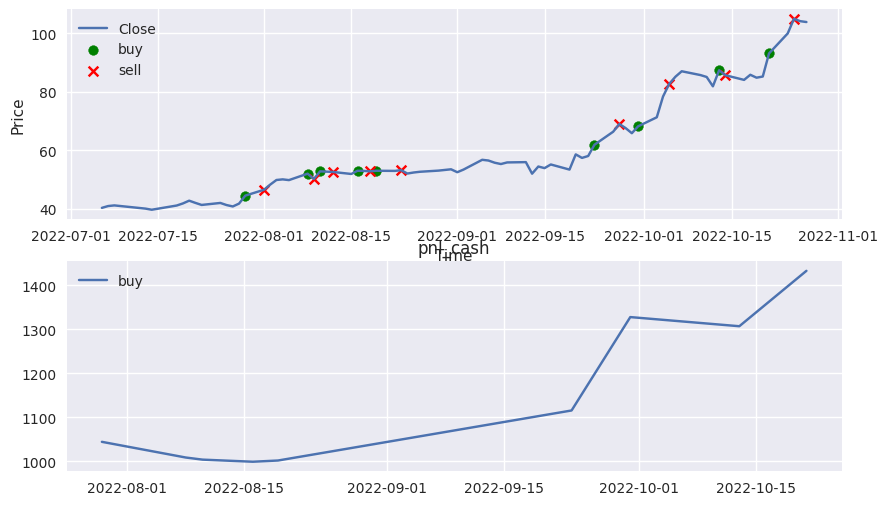

In [16]:
bt.bt_plot_strategy(df, trade)

In [6]:
#bt_dict_result = bt.make_backtest(df, range)
#bt_dict_result

In [7]:
#bt.write_backtest_result(df, SYMBOL, period, interval, bt_dict_result)

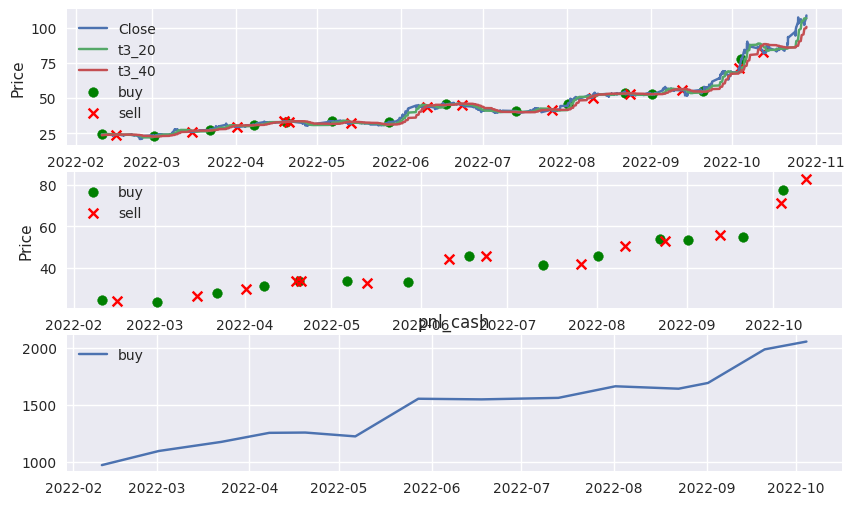

In [8]:
trade_sheet = bt.bt_crossover(df, 't3_20', 't3_40')
bt.bt_plot_crossover(df, trade_sheet, 't3_20', 't3_40')

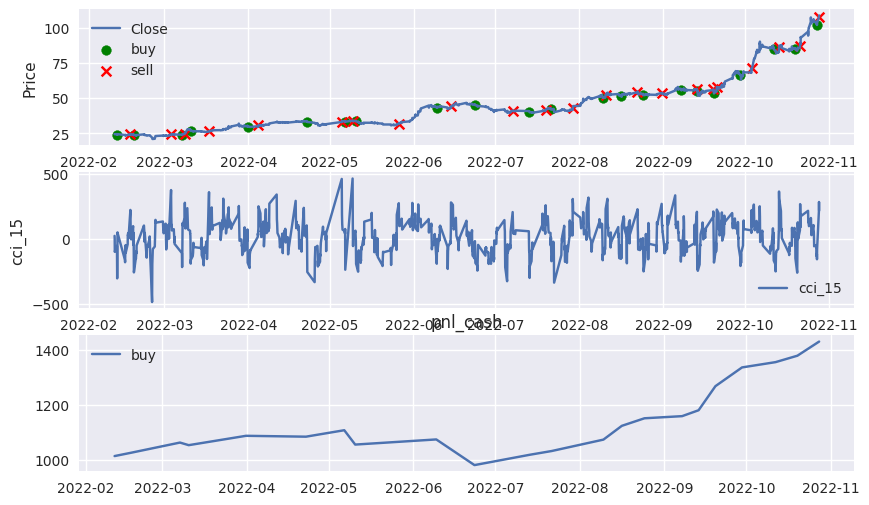

In [9]:
trade_sheet = bt.bt_threshold(df, 'cci_15', 200, -150)
bt.bt_plot_ind(df, trade_sheet, 'cci_15')

In [2]:
from twitter.twitter_collection import TwitterCollection
client = TwitterCollection()

Python-dotenv could not parse statement starting at line 11


Authentication Successfull


In [3]:
query_list = ['btc','eth','xrp','bnb', 'luna', 'matic', 'sol', 'ens']
query_list_bist = ['sumas', 'orma', 'xu100', 'bist', 'sasa']

In [7]:
query = 'xu100'
path_df = f'../data/tweets_data/{query}/'
file_df = f'{query}_tweets.csv'
client.throw_unnamed_cols(query, prefix='..')
df_tweet = client.get_tweets_df(query, path_df, file_df)
print(df_tweet.shape)
df_tweet.head()

(277611, 8)


,created_at,text,source,name,username,location,verified,description
index_col,,,,,,,,
0,2022-11-03 10:56:17+00:00,#XU100 #bist100 #x30yvade #thyao #kozal #EREGL...,Twitter Web App,Algotrader44,algotrader44,NaN,False,#VIOP VE KENDİ ÇAPIMDA #ALGOTRADE UZMAN ROBOT ...
1,2022-11-03 10:54:51+00:00,Geçtiğimiz bu zorlu yollarda hep önümüzde olup...,Twitter for Android,ÖM£R £R,MERERDO47975551,NaN,False,iki kapılı bir handa
2,2022-11-03 10:54:45+00:00,#PNSUT çarpanlarının makul olması ayrıca kâr m...,Twitter for Android,Ahmet KÜÇÜK,helalyatirim,NaN,False,Matematik öğretmeni. Borsa meraklısı. Uzun vad...
3,2022-11-03 10:48:27+00:00,#Alark Orta vade formasyon hedefi. Bilanço bek...,Twitter for Android,🚀TRADER🚀,SahinTrader,NaN,False,NaN
4,2022-11-03 10:42:56+00:00,bist gerçekten çok ucuz kaldı. yabancı gelse ç...,Twitter for iPhone,Kemal,tradermkr,"Adana, Türkiye",False,#mobtl #grsel #pcilt #inves #oyakc #seykm


In [11]:

query_list = ['btc','eth','xrp','bnb', 'luna', 'matic', 'sol', 'ens']
query_list_bist = ['sumas', 'orma', 'xu100', 'bist', 'sasa']

for i in ['sol', 'ens']:
    df_tweets = client.get_tweets_with_interval(i, 'en', hour=24*4)
    print(f'shape of {i} tweets df: {df_tweets.shape}')
    path_df = f'../data/tweets_data/{i}/'
    file_df = f'{i}_tweets.csv'
    client.write_tweets_csv(df_tweets, path_df, file_df)
    client.throw_unnamed_cols(i, prefix='..')

shape of sol tweets df: (240419, 8)


/mnt/c/Users/kozan/Desktop/Sen_Des_Proj/pr_borsa_code/KZ_project_setup/twitter/twitter_collection.py:103: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_tweets = pd.read_csv(os.path.join(pathdf, filedf))
/mnt/c/Users/kozan/Desktop/Sen_Des_Proj/pr_borsa_code/KZ_project_setup/twitter/twitter_collection.py:112: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_tweets = pd.read_csv(os.path.join(pathdf, filedf), index_col='index_col')


shape of ens tweets df: (165544, 8)


/mnt/c/Users/kozan/Desktop/Sen_Des_Proj/pr_borsa_code/KZ_project_setup/twitter/twitter_collection.py:103: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_tweets = pd.read_csv(os.path.join(pathdf, filedf))
/mnt/c/Users/kozan/Desktop/Sen_Des_Proj/pr_borsa_code/KZ_project_setup/twitter/twitter_collection.py:112: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_tweets = pd.read_csv(os.path.join(pathdf, filedf), index_col='index_col')
